# DDT QCD veto based on Autoencoder

In [1]:
import h5py
import numpy as np
import math

In [2]:
import matplotlib.pyplot as plt
plt.style.use('sonic.mplstyle')

In [3]:
# read the sideband dataset
#fileIN = h5py.File("../data/vae_eP/QCD_deltaEtaLt1.4_results.h5")
#rangeloss = (0., 10.)
fileIN = h5py.File("../data/vae_g/backgr_results.h5")
rangeloss = (0., 1.)

In [4]:
list(fileIN.keys())

['labels', 'results']

In [6]:
labels = fileIN.get("labels")
print(labels[:])

[b'mJJ' b'j1Pt' b'j1Eta' b'j1Phi' b'j1M' b'j1E' b'j2Pt' b'j2M' b'j2E'
 b'DeltaEtaJJ' b'DeltaPhiJJ' b'j1Loss' b'j2Loss']


In [7]:
data = np.array(fileIN.get("results"))
print(data.shape)

(979589, 13)


In [8]:
# apply the dijet mass cut
highMjj = data[:,0] > 700.
data = data[highMjj,:]
print(data.shape)

(471448, 13)


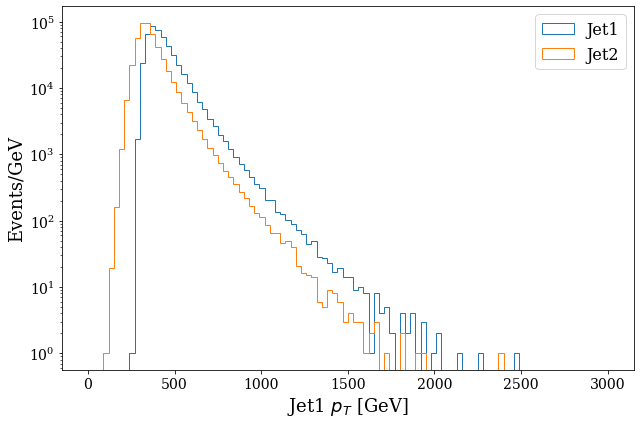

In [9]:
plt.figure(figsize=(9, 6))
plt.hist(data[:,1], range=(0.,3000.), bins=100, histtype='step', label = "Jet1")
plt.hist(data[:,6], range=(0.,3000.), bins=100, histtype='step', label = "Jet2")
plt.semilogy()
plt.xlabel("Jet1 $p_T$ [GeV]")
plt.ylabel("Events/GeV")
plt.legend()
plt.show()

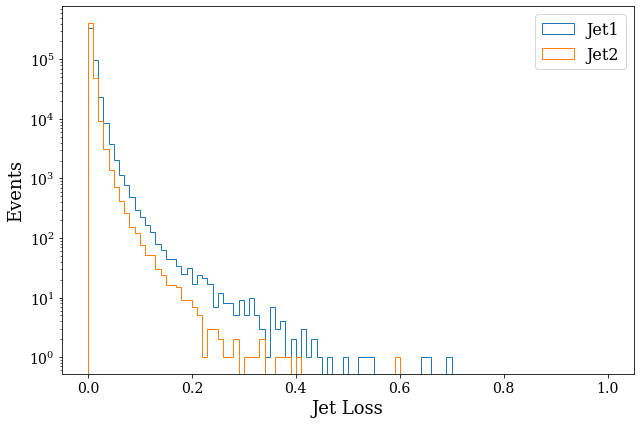

In [10]:
plt.figure(figsize=(9, 6))
plt.hist(data[:,-2], range=rangeloss, bins=100, histtype='step', label = "Jet1")
plt.hist(data[:,-1], range=rangeloss, bins=100, histtype='step', label = "Jet2")
plt.semilogy()
plt.xlabel("Jet Loss")
plt.ylabel("Events")
plt.legend()
plt.show()

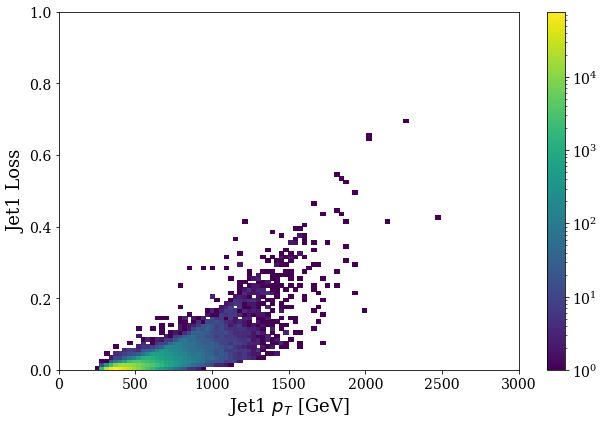

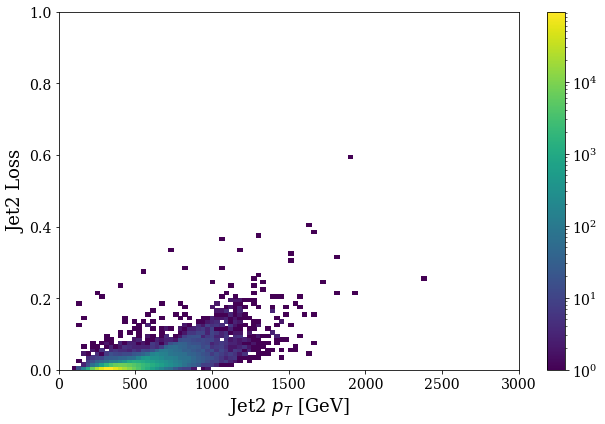

In [11]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,1], data[:,-2],range=((0.,3000.,),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1 Loss")
plt.xlabel("Jet1 $p_T$ [GeV]")
plt.colorbar()
plt.draw()
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,6], data[:,-1],range=((0.,3000.,),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet2 Loss")
plt.xlabel("Jet2 $p_T$ [GeV]")
plt.colorbar()
plt.draw()

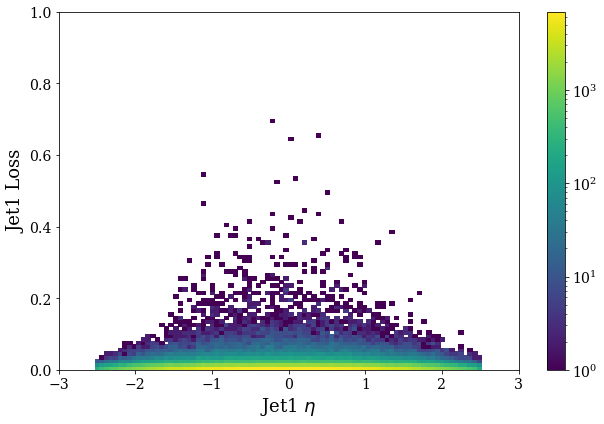

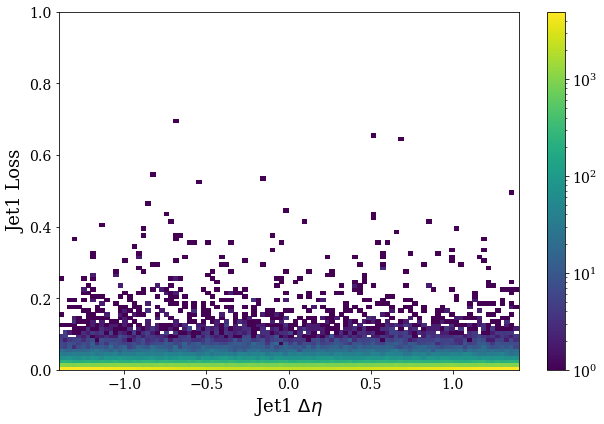

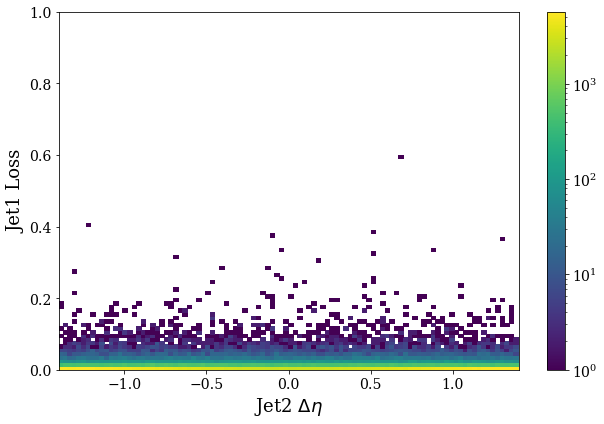

In [12]:
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,2], data[:,-2],range=((-3.,3.),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1 Loss")
plt.xlabel("Jet1 $\eta$")
plt.colorbar()
plt.draw()
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,9], data[:,-2],range=((-1.4,1.4),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1 Loss")
plt.xlabel("Jet1 $\Delta\eta$")
plt.colorbar()
plt.draw()
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,9], data[:,-1],range=((-1.4,1.4),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1 Loss")
plt.xlabel("Jet2 $\Delta\eta$")
plt.colorbar()
plt.draw()

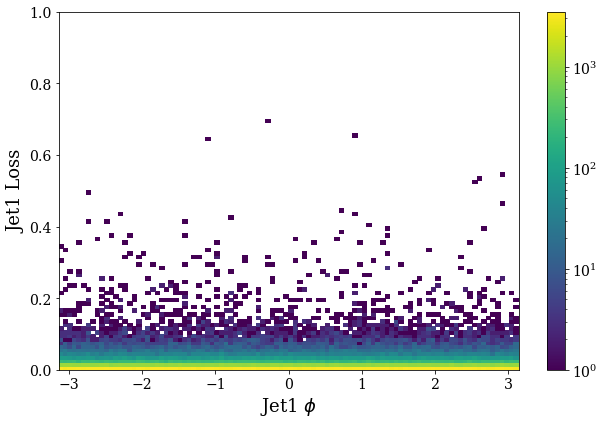

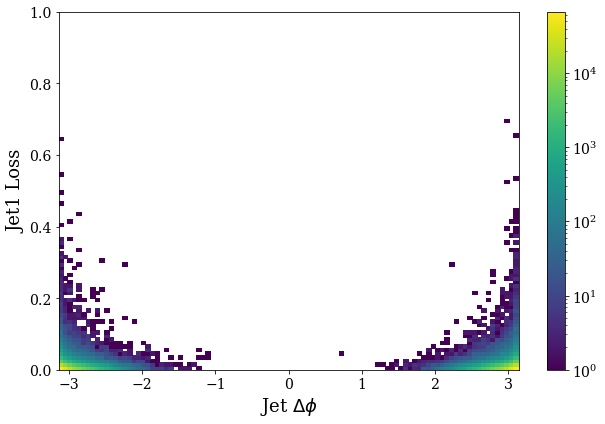

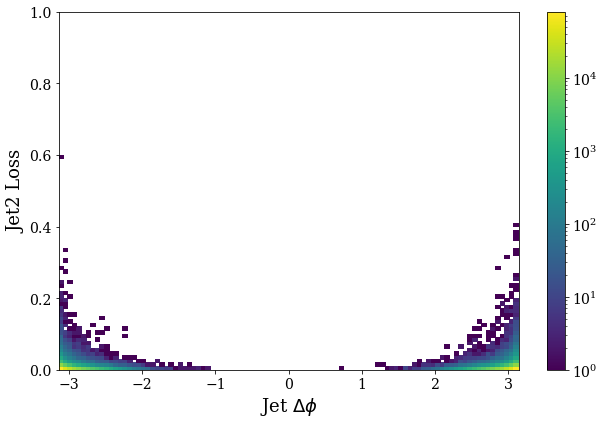

In [13]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,3], data[:,-2],range=((-3.142,3.142),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1 Loss")
plt.xlabel("Jet1 $\phi$")
plt.colorbar()
plt.draw()
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,10], data[:,-2],range=((-3.142,3.142),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1 Loss")
plt.xlabel("Jet $\Delta\phi$")
plt.colorbar()
plt.draw()
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,10], data[:,-1],range=((-3.142,3.142),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet2 Loss")
plt.xlabel("Jet $\Delta\phi$")
plt.colorbar()
plt.draw()

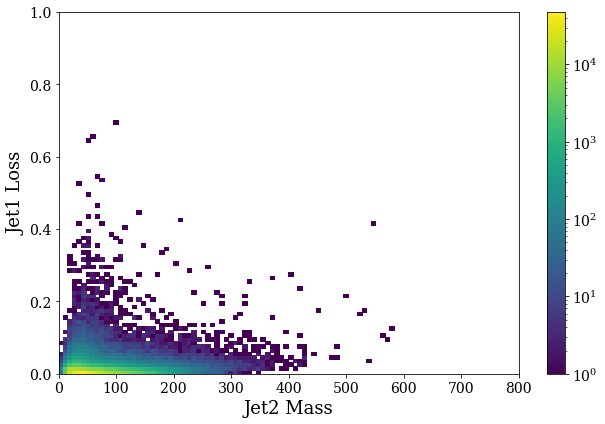

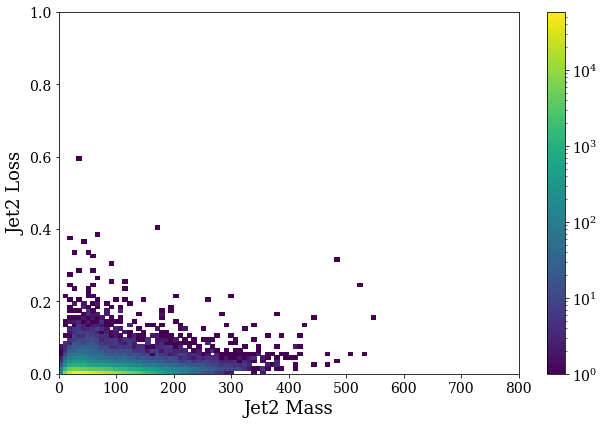

In [14]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,4], data[:,-2],range=((0.,800.),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1 Loss")
plt.xlabel("Jet2 Mass")
plt.colorbar()
plt.draw()
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,7], data[:,-1],range=((0.,800.),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet2 Loss")
plt.xlabel("Jet2 Mass")
plt.colorbar()
plt.draw()

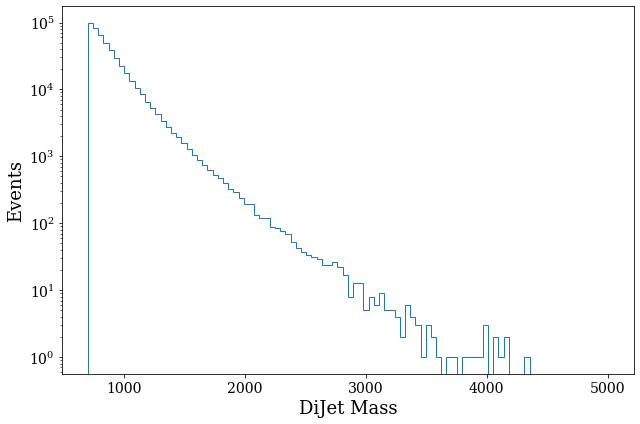

In [15]:
plt.figure(figsize=(9, 6))
plt.hist(data[:,0], range=(700.,5000.), bins=100, histtype='step')
plt.semilogy()
plt.xlabel("DiJet Mass")
plt.ylabel("Events")
plt.show()

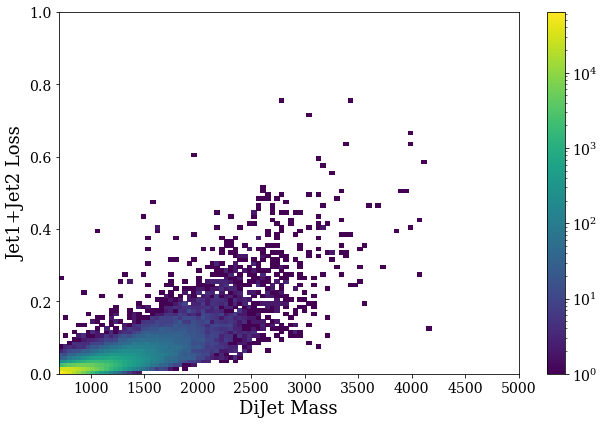

In [16]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,0], data[:,-2]+data[:,-1],range=((700.,5000.),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1+Jet2 Loss")
plt.xlabel("DiJet Mass")
plt.colorbar()
plt.draw()

In [17]:
# separate the sample in iBin bins with comparable statistics
mjjVal = data[:,0]
mjjVal = np.sort(mjjVal)
iBin = 100
binStat = int(len(mjjVal)/iBin)
mjjBins = []
for i in range(iBin+1):
    mjjBins.append(int(mjjVal[i*binStat]))
mjjBins[-1] = max(mjjBins[-1], 5000.)
mjjBinMin = mjjBins[:-1]
mjjBinMax = mjjBins[1:]
print(mjjBinMin)
print(mjjBinMax)

[700, 701, 703, 705, 707, 709, 711, 713, 715, 717, 719, 721, 724, 726, 728, 730, 732, 734, 736, 739, 741, 743, 745, 748, 750, 752, 754, 757, 759, 762, 764, 767, 769, 772, 774, 777, 780, 782, 785, 788, 791, 794, 796, 799, 802, 805, 809, 812, 815, 818, 822, 825, 829, 832, 836, 840, 843, 847, 852, 856, 860, 864, 869, 873, 878, 883, 888, 893, 899, 904, 910, 916, 922, 929, 936, 943, 950, 958, 966, 975, 984, 994, 1004, 1015, 1026, 1038, 1052, 1066, 1082, 1100, 1119, 1141, 1165, 1194, 1228, 1268, 1318, 1387, 1485, 1668]
[701, 703, 705, 707, 709, 711, 713, 715, 717, 719, 721, 724, 726, 728, 730, 732, 734, 736, 739, 741, 743, 745, 748, 750, 752, 754, 757, 759, 762, 764, 767, 769, 772, 774, 777, 780, 782, 785, 788, 791, 794, 796, 799, 802, 805, 809, 812, 815, 818, 822, 825, 829, 832, 836, 840, 843, 847, 852, 856, 860, 864, 869, 873, 878, 883, 888, 893, 899, 904, 910, 916, 922, 929, 936, 943, 950, 958, 966, 975, 984, 994, 1004, 1015, 1026, 1038, 1052, 1066, 1082, 1100, 1119, 1141, 1165, 1194, 122

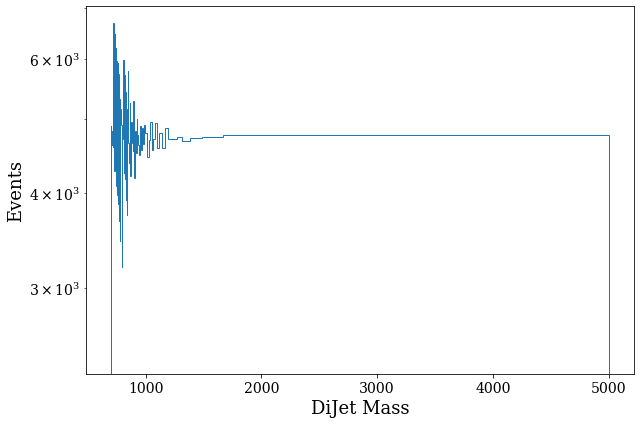

In [19]:
# Verify that the number of events/bin is reasonably flat
plt.figure(figsize=(9, 6))
plt.hist(data[:,0], range=(700.,5000.), bins=mjjBins, histtype='step', density=False)
plt.semilogy()
plt.xlabel("DiJet Mass")
plt.ylabel("Events")
plt.show()

In [20]:
# in each bin, look for the (loss1+loss2) corresponding to a 1E-3 percentile
FPR = 0.5
lossCut = []
for i in range(len(mjjBinMin)):
    minMjj = mjjBinMin[i]
    maxMjj = mjjBinMax[i]
    myMask = (data[:,0]>=minMjj)*(data[:,0]<maxMjj)
    dataBin = data[myMask,:]
    loss = np.sort(dataBin[:,-1]+dataBin[:,-2])
    percentile = int(len(loss)*FPR)
    print(percentile,dataBin.shape)
    print(loss[-percentile],loss[-percentile-1])
    lossCut.append(loss[-percentile])
lossCut = np.array(lossCut)
print(lossCut)

1217 (2434, 13)
0.007915812267706542 0.007914340354549132
2451 (4902, 13)
0.007880387228739285 0.007877495772154661
2409 (4818, 13)
0.008051854958280636 0.008051105276528763
2391 (4783, 13)
0.008057915421044313 0.00805578732913904
2388 (4776, 13)
0.008124791350336679 0.008123647382042572
2416 (4832, 13)
0.008199345419599782 0.008198254680494364
2314 (4628, 13)
0.008187737003897227 0.008180875297413782
2341 (4683, 13)
0.00827667688278471 0.008274816523892184
2301 (4602, 13)
0.008333083654595178 0.008332735874277202
2330 (4661, 13)
0.00827312536041103 0.008270707508827599
2308 (4617, 13)
0.008424589155025903 0.008419089674017133
3344 (6689, 13)
0.008367228367260084 0.008366760080377606
2266 (4533, 13)
0.008369183563476412 0.008365856451934751
2242 (4484, 13)
0.008470316029892526 0.00846941060448
2170 (4341, 13)
0.008358319971412575 0.008358173887891025
2135 (4271, 13)
0.008484026890574117 0.008481467234150636
2185 (4371, 13)
0.008680163494876802 0.008677649594727183
2204 (4409, 13)
0.008

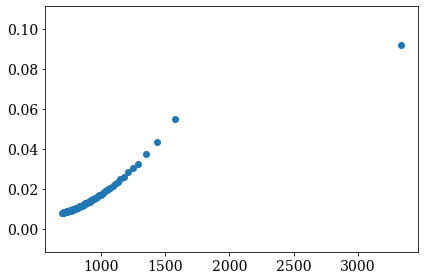

In [22]:
# plot the threshold value vs bin center
mjjBinCenter = (np.array(mjjBinMin)+np.array(mjjBinMax))/2
plt.scatter(mjjBinCenter, lossCut)

In [23]:
# use  np.interp  to define the threshold(mJJ) function
mJJval = 1500.
print(np.interp(mJJval,mjjBinCenter,lossCut))

0.04854218812552115


In [24]:
# Define the accept (anomalies) and reject (standard QCD) datasets
# ON THE QCD SIGNAL DATASET [NOT YET AVAILABLE, SO WE USE THE SAME HERE]
mJJval = np.array(data[:,0])
loss = data[:,-1]+data[:,-2]
threshold = np.interp(mJJval, mjjBinCenter,lossCut)

In [25]:
mJJ_QCD_pass = mJJval[loss>=threshold]
mJJ_QCD_reject = mJJval[loss<threshold]

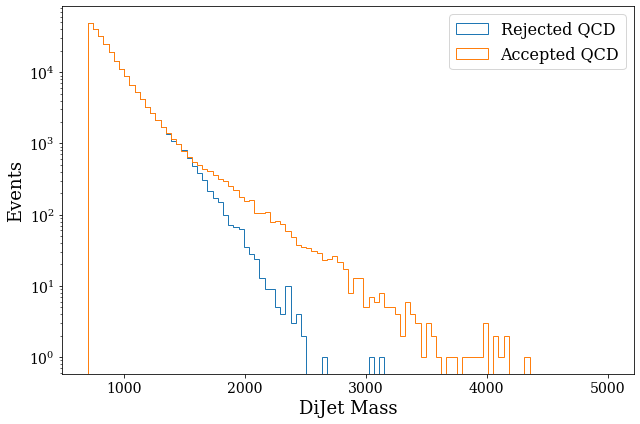

In [26]:
plt.figure(figsize=(9, 6))
plt.hist(mJJ_QCD_reject, range=(700.,5000.), bins=100, histtype='step', label="Rejected QCD")
plt.hist(mJJ_QCD_pass, range=(700.,5000.), bins=100, histtype='step', label="Accepted QCD")
plt.semilogy()
plt.xlabel("DiJet Mass")
plt.ylabel("Events")
plt.legend()
plt.show()

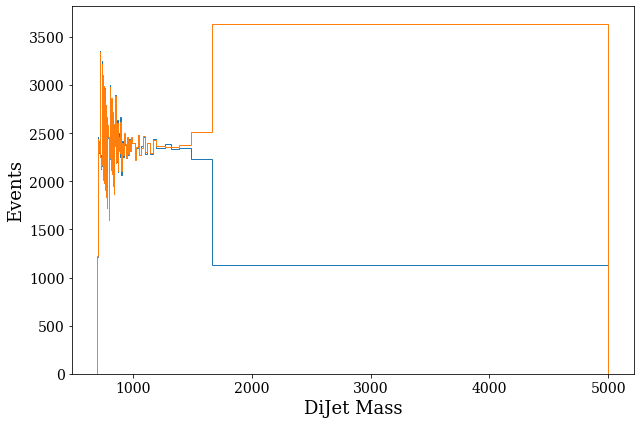

In [27]:
plt.figure(figsize=(9, 6))
rejected = plt.hist(mJJ_QCD_reject, range=(700.,5000.), bins=mjjBins, histtype='step', density=False, label="Rejected QCD")
accepted = plt.hist(mJJ_QCD_pass, range=(700.,5000.), bins=mjjBins, histtype='step', density=False, label="Accepted QCD")
plt.xlabel("DiJet Mass")
plt.ylabel("Events")
plt.show()

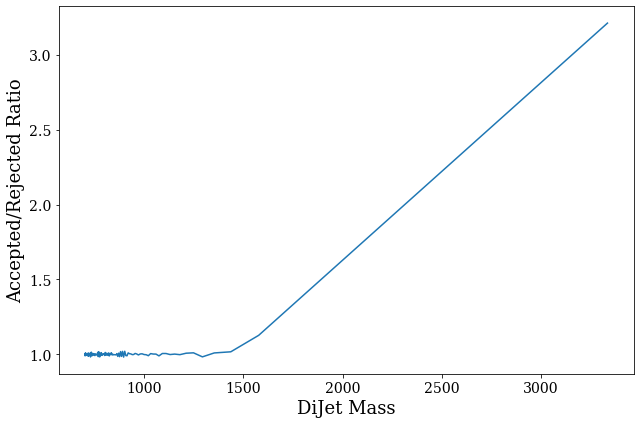

In [28]:
plt.figure(figsize=(9, 6))
values = plt.plot(mjjBinCenter, accepted[0]/rejected[0])
plt.xlabel("DiJet Mass")
plt.ylabel("Accepted/Rejected Ratio")
plt.show()

In [29]:
# in each bin, look for the (loss1+loss2) corresponding to a 1E-3 percentile
FPR = 0.5
eff = []
err = []
for i in range(len(mjjBinMin)):
    minMjj = mjjBinMin[i]
    maxMjj = mjjBinMax[i]
    myMask = (mJJval>=minMjj)*(mJJval<maxMjj)
    dataBin = mJJval[myMask]
    nPass = np.sum(loss[myMask]>=threshold[myMask])
    nReject = np.sum(myMask)-nPass
    eff.append(float(nPass/(nPass+nReject)))
    err.append(math.sqrt(eff[i]*(1.-eff[i])/(nPass+nReject)))
    print("%.3f +/- %.3f" %(eff[i],err[i]))

0.501 +/- 0.010
0.497 +/- 0.007
0.502 +/- 0.007
0.498 +/- 0.007
0.501 +/- 0.007
0.501 +/- 0.007
0.498 +/- 0.007
0.499 +/- 0.007
0.502 +/- 0.007
0.497 +/- 0.007
0.502 +/- 0.007
0.499 +/- 0.006
0.498 +/- 0.007
0.502 +/- 0.007
0.496 +/- 0.008
0.502 +/- 0.008
0.504 +/- 0.008
0.498 +/- 0.008
0.498 +/- 0.006
0.502 +/- 0.008
0.501 +/- 0.008
0.498 +/- 0.008
0.501 +/- 0.006
0.500 +/- 0.008
0.498 +/- 0.008
0.501 +/- 0.008
0.500 +/- 0.006
0.500 +/- 0.008
0.499 +/- 0.006
0.499 +/- 0.008
0.503 +/- 0.007
0.496 +/- 0.008
0.504 +/- 0.007
0.501 +/- 0.008
0.496 +/- 0.007
0.502 +/- 0.007
0.499 +/- 0.009
0.503 +/- 0.007
0.498 +/- 0.007
0.499 +/- 0.007
0.501 +/- 0.007
0.500 +/- 0.009
0.501 +/- 0.007
0.498 +/- 0.007
0.503 +/- 0.007
0.499 +/- 0.006
0.502 +/- 0.007
0.498 +/- 0.008
0.500 +/- 0.008
0.502 +/- 0.007
0.497 +/- 0.008
0.501 +/- 0.007
0.499 +/- 0.008
0.503 +/- 0.007
0.499 +/- 0.007
0.500 +/- 0.008
0.499 +/- 0.007
0.499 +/- 0.007
0.499 +/- 0.007
0.499 +/- 0.008
0.501 +/- 0.008
0.496 +/- 0.007
0.502 +/

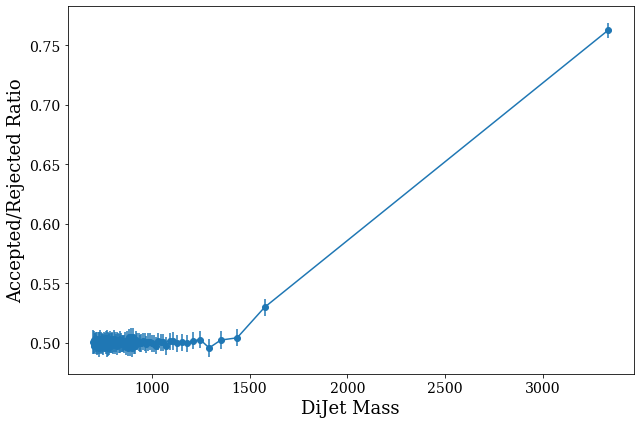

In [30]:
plt.figure(figsize=(9, 6))
plt.errorbar(mjjBinCenter, eff, yerr=np.array(err), fmt='-o')
plt.xlabel("DiJet Mass")
plt.ylabel("Accepted/Rejected Ratio")
plt.show()